<a href="https://colab.research.google.com/github/yuxing-zhang/Playground/blob/master/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will implement the Transformer model proposed in [Attention Is All You Need](https://arxiv.org/abs/1706.03762). Below is an illustration of its structure.

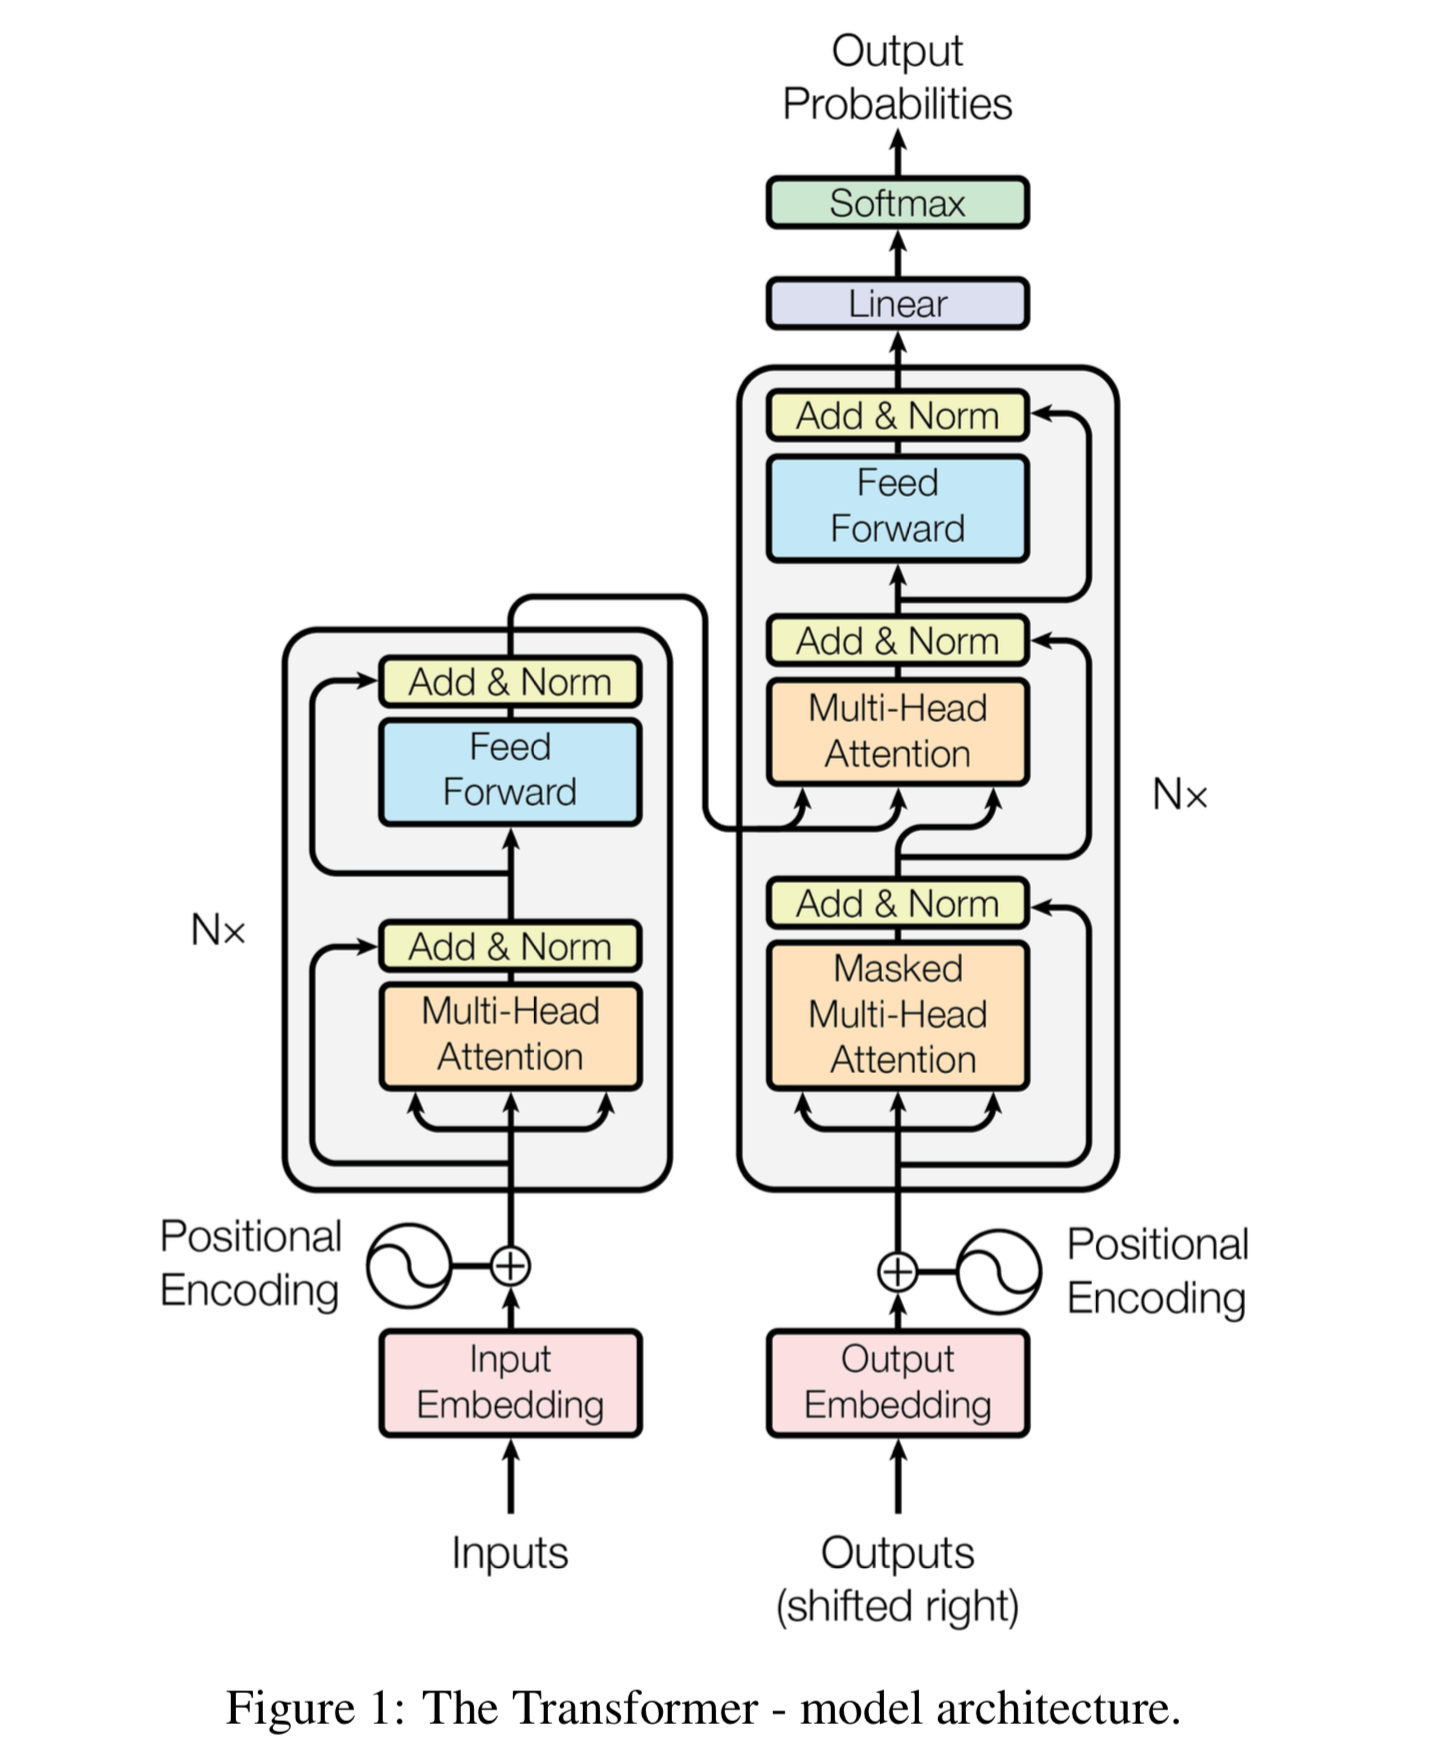

It can be seen that the Transformer has a layered architecture, where each component consisits of multiple layers which themselves contain multiple sublayers. Hence, it is natural to implement this model as nested classes.

In [ ]:
import torch
import torch.nn as nn
import math
from copy import deepcopy

# Helper function to duplicate layers
def clone(module, n):
    return nn.ModuleList([deepcopy(module) for _ in range(n)])

# The transformer is an encoder-decoder architecture
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, src, tgt):
        return self.decoder(encoder(src), tgt)

# The encoder is a multi-layer structure 
class Encoder(nn.Module):
    def __init__(self, encoder_layer, n=6):
        super(Encoder, self).__init__()
        self.layers = clone(encoder_layer, n)
    def forward(self, src):
        for l in self.layers:
            src = l(src)
        return src

# Each encoder layer contains a multi-head attention layer
# and a feed forward layer
class EncoderLayer(nn.Module):
    def __init__(self, ff, attn):
        super(EncoderLayer, self).__init__()
        self.sublayers = clone(sublayer, 2)
        self.ff = ff
        self.attn = attn
    def forward(self, src):
        return self.sublayers[1](self.ff, self.sublayers[0](
            lambda x: self.attn(x, x, x), src))

# Dropout, layer normalization and residual connection are applied
# in each sublayer
class SubLayer(nn.Module):
    def __init__(self, d_model, dropout=.1):
        super(SubLayer, self).__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, f, x):
        return x + self.dropout(f(self.norm(x)))

# Attention mechanism
def attention(query, key, value, mask=None, dropout=None):
    score = torch.matmul(query, key.transpose(-2, -1)) / sqrt(query.size(-1))
    if mask:
        score += mask
    score = F.softmax(score, dim=-1)
    if dropout:
        score = dropout(score)
    return torch.matmul(score, value), score

# Multihead attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, mask=False):
        super(MultiHeadAttention, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for
            _ in range(4)])
        self.h = h
        self.d_k = d_model // h
        self.mask = mask
    def forward(self, q, k, v):
        num_batches, length = q.size(0), q.size(1)
        mask = None
        # Mask restricts attention to only previous tokens
        if self.mask:
            mask = torch.zeros(length, length).masked_fill_(
                        torch.triu(torch.ones(length, length)) == 1,
                        -float('inf'))
        # Original shape of q, k, v: [num_batches, length, d_model]
        # New shape: [num_batches, h, length, d_model/h]
        q, k, v = [l(x).view(num_batches, -1, self.h, self.d_k).transpose(-2,
                -3) for (l, x) in zip(self.linears[:3], (q, k, v))]
        attn, score = attention(q, k, v, mask)
        attn = attn.transpose(-2, -3).view(num_batches, -1, d_model)\
                .contiguous()
        return self.linears[-1](attn)

# The decoder is also a multi-layer structure similar to the encoder
class Decoder(nn.Module):
    def __init__(self, decoder_layer, n=6):
        super(Decoder, self).__init__()
        self.layers = clone(decoder_layer, n)
    def forward(self, mmr, tgt):
        for l in self.layers:
            tgt = l(mmr, tgt)
        return tgt

# Each decoder layer contains a self-attention layer, a multi-head
# attention layer and a feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, ff, tgt_attn, mmr_attn):
        super(DecoderLayer, self).__init__()
        self.sublayers = clone(sublayer, 3)
        self.tgt_attn = tgt_attn
        self.mmr_attn = mmr_attn
        self.ff = ff
    def forward(self, mmr, tgt):
        l = self.sublayers
        tgt = l[0](lambda x: self.tgt_attn(x, x, x), tgt)
        tgt = l[1](lambda x: self.mmr_attn(x, mmr, mmr), tgt)
        tgt = l[2](ff, tgt)
        return tgt

# Positional encoding
def pe(length, d_model):
    pos = torch.arange(length).unsqueeze(dim=1)
    div = torch.exp(-torch.arange(0, d_model, 2, dtype=torch.float) *\
            math.log(10000) / d_model)
    pe = torch.zeros(length, d_model)
    pe[::2] = torch.sin(pos * div)
    pe[1::2] = torch.cos(pos * div)

# Build a Transformer
# Model hyperparameters
d_model = 512
h = 8
d_ff = 2048
m_len = 128
n = 6
dropout = .1

# A generic sublayer
sublayer = SubLayer(d_model, dropout)
# Feed-forward layer
ff = nn.Sequential(nn.Linear(d_model, d_ff),
                   nn.ReLU(),
                   nn.Linear(d_ff, d_model)
)
# Attention layer for the encoder
src_attn = MultiHeadAttention(h, d_model)
# Attention layer for the memory
mmr_attn = MultiHeadAttention(h, d_model)
# Attention layer for the target
tgt_attn = MultiHeadAttention(h, d_model, mask=True)

# Build the encoder
encoder_layer = EncoderLayer(ff, src_attn)
encoder = Encoder(encoder_layer, n)

# Build the decoder
decoder_layer = DecoderLayer(ff, tgt_attn, mmr_attn)
decoder = Decoder(decoder_layer, n)

transformer = Transformer(encoder, decoder)
print(transformer)

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (sublayers): ModuleList(
          (0): SubLayer(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SubLayer(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (ff): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (attn): MultiHeadAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True